# Self-Stabilizing Gaussian Mixture Models (SGMM)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/paradoxysm/dsigm/blob/master/doc/guides/stabilization_analysis.ipynb)

The SGMM is a modified Gaussian Mixture Model that integrates an optimization of the ideal number of gaussian components in step with the Expectation Maximization algorithm.

This is a guide that sets out how the SGMM determines the ideal number of components. Included will be comparisons and analyses to validate the stabilization of SGMM, along with timing analysis.

In [0]:
!python --version
!git clone https://github.com/paradoxysm/dsigm.git
!git -C /content/dsigm/ pull
import sys
sys.path.append('/content/dsigm')

from dsigm.mixture import SGMM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.datasets import make_spd_matrix
sns.set()

from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, color=None, **kwargs):
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, facecolor=color, **kwargs))

def plot(X, params=None, ax=None, color=None):
    ax = ax or plt.gca()
    labels = None
    if params is not None:
        labels = params['labels']
        mu, sigma, delta = params['mu'], params['sigma'], params['delta']
        delta_factor = 0.2 / max(delta)
        for m, s, w in zip(mu, sigma, delta):
            draw_ellipse(m, s, alpha=w * delta_factor, color=color)
    if labels is not None:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=5, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=5, zorder=2)
    ax.axis('equal')

## Self-Stabilization Algorithm

The Gaussian Mixture Model (GMM) is a versatile and popular clustering and generative model. However, one of its key limitations is the necessity to define and select *k*, the number of component distributions that underly the distribution mixture.

A number of attempts at automatically selecting the optimal *k* (we'll call it *k'* from now on) have been made. A well-known example is the Drichlet Process GMM. However, sometimes it can produce sub-optimal number of clusters or underfit the data.

/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


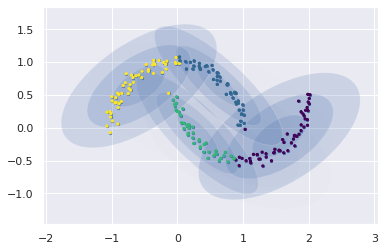

In [2]:
from sklearn.mixture import BayesianGaussianMixture
from sklearn.datasets import make_moons

# create some irregular data
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1], s=5)

# bgmm model - based on the Drichlet Process
gmm = BayesianGaussianMixture(n_components=10)
gmm.fit(Xmoon)

# get the model parameters
params = {'mu': [], 'sigma':[], 'delta':[], 'labels':None}
params['mu'] = gmm.means_
params['sigma'] = gmm.covariances_
params['delta'] = gmm.weights_
params['labels'] = gmm.predict(Xmoon)

# plot the results
plot(Xmoon, params=params)

Other attempts involve beginning with a Gaussian Mixture with one component and iteratively increasing the number of components until an optimal is reached.

This is usually acceptable should the optimal *k'* be small, but should it be substantially large, the incremental nature of these attempts can become a detriment.

To combat this, SGMM approaches this problem through a narrowing search interval. The algorithm first orients itself with the initial *k* to determine an interval where *k'* is contained. It continues to evaluate the midpoint of this interval to reduce the interval by up to half until the interval converges to size of one, giving us *k'*.

Finally, to get a better estimate, SGMM calculates ABIC, a composite average of the Akaike and Bayesian Information Criteria (AIC and BIC, respectively).

AIC and BIC are both common measures for model selection that aim to find the best fitting model without overfitting. BIC uses a heavier penalty for overfitting than AIC.

### 1. Orientation

As SGMM initializes with a specified number of components, *i*, the algorithm begins an orientation process to initialize the search interval.

It first determines if *i* components result in an underfitted or overfitted model, by evaluating the ABIC when the model has *i* and *i*+1 components. 

If the gradient between these scores is positive, the model is overfitted and *k'* is located within [1, *i*+1]. If the gradient is negative, the model is underfitted and we seek some early *j* > *i*+1 that causes overfitting, such that *k'* is located within [*i*+1, *j*]. 

This is accomplished by taking some *j* based on the gradient with the previous maximum and *i* repeatedly until the ABIC score at *j* is larger than the mean of all evaluated *j*'s. This allows us to capture a *j* that is relatively close to the optimal and prevent an overly large interval.

### 2. Narrowing the Interval

To narrow the interval, we find the midpoint of the current interval with its corresponding ABIC score. Based on this score in relation to the upper and lower limits of the interval, we can make conclusions on which half of the interval contains *k'*.

### 3. Selecting Optimal Number of Components

SGMM continues to repeatedly narrow the interval until the interval has no midpoints (i.e. [*a*, *a*+1], for some *i* < *a* ≤ *j*). Whichever limit, upper or lower, corresponds to the lowest ABIC score is determined to be *k'*.

## Validating Self-Stabilization

Now that we understand the basic steps of the self-stabilization algorithm, let's view some examples with data to see it in action.

We're starting out with a prototypical K-means or Gaussian Mixture Model killer (`sklearn.datasets.make_moons`) as simpler clearly defined clusters are readily demonstrated with our 1D ([here](https://github.com/paradoxysm/dsigm/blob/master/doc/guides/SGMM_1D.ipynb)) and 2D guides ([here](https://github.com/paradoxysm/dsigm/blob/master/doc/guides/SGMM_2D.ipynb)).

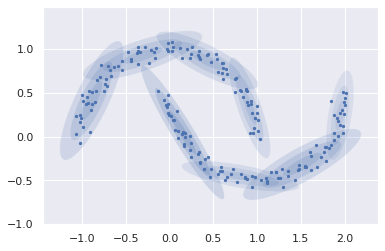

In [0]:
sgmm = SGMM(init_cores=4)
sgmm.fit(Xmoon)

# get the model parameters
params = {'mu': [], 'sigma':[], 'delta':[], 'labels':None}
for c in sgmm.cores:
    params['mu'].append(c.mu)
    params['sigma'].append(c.sigma)
    params['delta'].append(c.delta)

# plot the results
print("Number of Components:", len(sgmm.cores))
plot(Xmoon, params=params)

As you can see, the SGMM fits the data quite well, despite the initial number of components set at 4, clearly a poor choice in hindsight.

To verify this is, by a quantitative measure, an ideal number of components, let's examine the BIC and AIC scores for a range of components.

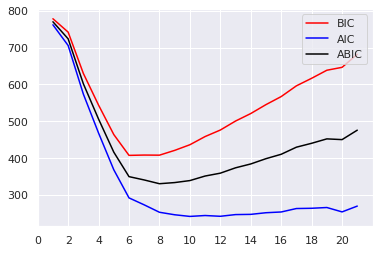

In [3]:
def icplot(data):
    bic, aic, abic = [], [], []
    for i in range(1, 22):
        gmm = SGMM(init_cores=i, stabilize=None)
        gmm.fit(data)
        bic.append(gmm.bic(data))
        aic.append(gmm.aic(data))
        abic.append(gmm.abic(data))

    # plot the results
    bins = np.arange(1, 22)
    plt.plot(bins, bic, color='red', label='BIC')
    plt.plot(bins, aic, color='blue', label='AIC')
    plt.plot(bins, abic, color='black', label='ABIC')
    plt.xticks(np.arange(0, 21, 2))
    plt.legend(loc='upper right')
    plt.show()

icplot(Xmoon)

As you can see the minima for the BIC curve is when the model contains 6 components, while for the AIC, it is when the model contains 10-12 components. The ABIC curve minimizes at 8 components.

Comparing the best model according to each of these criteria, we get the following models.

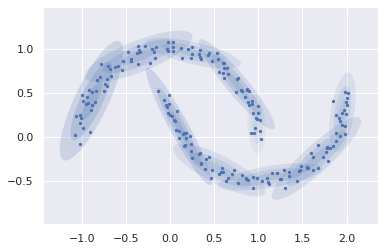

In [0]:
# AIC minimized
sgmm = SGMM(init_cores=10, stabilize=False)
sgmm.fit(Xmoon)

# get the model parameters
params = {'mu': [], 'sigma':[], 'delta':[], 'labels':None}
for c in sgmm.cores:
    params['mu'].append(c.mu)
    params['sigma'].append(c.sigma)
    params['delta'].append(c.delta)

# plot the results
print("Number of Components:", len(sgmm.cores))
plot(Xmoon, params=params)

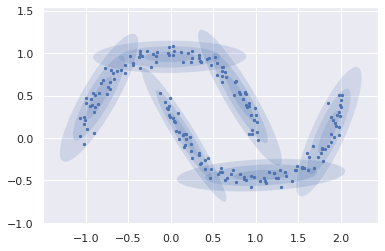

In [0]:
# BIC minimized
sgmm = SGMM(init_cores=6, stabilize=False)
sgmm.fit(Xmoon)

# get the model parameters
params = {'mu': [], 'sigma':[], 'delta':[], 'labels':None}
for c in sgmm.cores:
    params['mu'].append(c.mu)
    params['sigma'].append(c.sigma)
    params['delta'].append(c.delta)

# plot the results
print("Number of Components:", len(sgmm.cores))
plot(Xmoon, params=params)

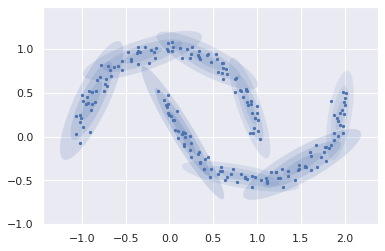

In [0]:
# ABIC minimized
sgmm = SGMM(init_cores=8, stabilize=False)
sgmm.fit(Xmoon)

# get the model parameters
params = {'mu': [], 'sigma':[], 'delta':[], 'labels':None}
for c in sgmm.cores:
    params['mu'].append(c.mu)
    params['sigma'].append(c.sigma)
    params['delta'].append(c.delta)

# plot the results
print("Number of Components:", len(sgmm.cores))
plot(Xmoon, params=params)

We can visually see that 10 components according to AIC does look to fit the data very well, even better than 8 components. However, we begin to run the distinct possibility of overfitting and unnecessary components. BIC results in a number of components likely too low for our needs, the components are practically overlapping between the two crescent distributions. ABIC makes for a well fitted model.

In most cases, AIC and BIC agree, but we showed this example to demonstrate that the usage of both criteria in combination is more versatile in leading to better models.

Let's try it with some more data. As a reminder, SGMM by default initializes with 5 components, so what we see is clearly a result of self-stabilization.

Number of Components: 16


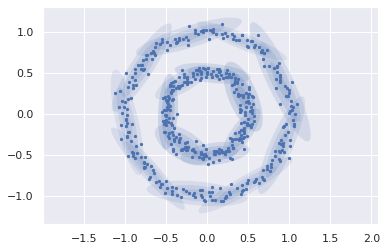

In [4]:
from sklearn.datasets import make_circles

Xcircle, ycircle = make_circles(500, noise=.05, factor=0.5, random_state=0)

sgmm = SGMM()
sgmm.fit(Xcircle)

# get the model parameters
params = {'mu': [], 'sigma':[], 'delta':[], 'labels':None}
for c in sgmm.cores:
    params['mu'].append(c.mu)
    params['sigma'].append(c.sigma)
    params['delta'].append(c.delta)

# plot the results
print("Number of Components:", len(sgmm.cores))
plot(Xcircle, params=params)

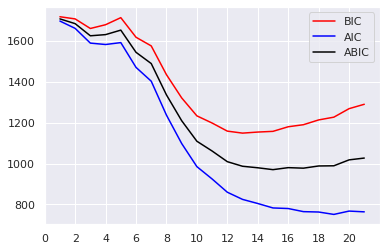

In [5]:
# plot the BIC, AIC, ABIC curves
icplot(Xcircle)

Here we can actually see that the model has chosen a slghtly higher *k* than we might actually think necessary. Of course, SGMM is capable of weighting the composite of AIC and BIC, so we could optimize with BIC at a greater weight if we preferred smaller *k*.

Number of Components: 14


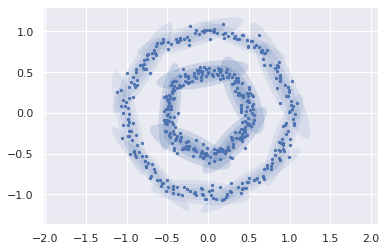

In [6]:
sgmm = SGMM(stabilize=1)
sgmm.fit(Xcircle)

# get the model parameters
params = {'mu': [], 'sigma':[], 'delta':[], 'labels':None}
for c in sgmm.cores:
    params['mu'].append(c.mu)
    params['sigma'].append(c.sigma)
    params['delta'].append(c.delta)

# plot the results
print("Number of Components:", len(sgmm.cores))
plot(Xcircle, params=params)

Number of Components: 3


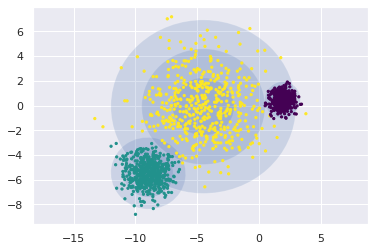

In [8]:
from sklearn.datasets import make_blobs

Xblob, yblob = make_blobs(1500, cluster_std=[1.0, 2.5, 0.5], random_state=170)

sgmm = SGMM()
sgmm.fit(Xblob)

# get the model parameters
params = {'mu': [], 'sigma':[], 'delta':[], 'labels':None}
for c in sgmm.cores:
    params['mu'].append(c.mu)
    params['sigma'].append(c.sigma)
    params['delta'].append(c.delta)
params['labels'] = sgmm.predict(Xblob)

# plot the results
print("Number of Components:", len(sgmm.cores))
plot(Xblob, params=params)

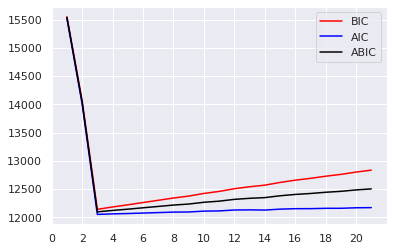

In [9]:
# plot the BIC, AIC, ABIC curves
icplot(Xblob)

## Timing Analysis

As one can tell, this algorithm does take time as it is essentially fitting various Gaussian Mixture Models across various number of components.

The question is: how does it compare to other algorithms?

Obviously, compared to the basic Gaussian Mixture Model is going to see drastically slower runtimes. But we know this - SGMM is running multiple GMMs iteratively!

So instead, it's more fair to compare to the other stabilizing GMMs that we mentioned earlier, namely algorithms that begin with one component and iteratively expand until *k'* is reached. We'll call these algorithms Iterative Gaussian Mixture Models (IGMMs) just for simplicity. IGMMs require a fitting attempt *k'*+1 times.

On the other hand, SGMMs use a halving search interval. Orientation requires at minimum 3 fitting attempts. Its upper limit depends more on what we provide as an initial number of cores. Normally, it requires no more than 3 additional attempts. The interval search requires at minimum 1 fitting attempt and up to 3 fitting attempts per halving.

Putting these together, we can see that with small *k'*, IGMMs require fewer fitting attempts. But when *k'* gets large, SGMMs can overtake in efficiency.

So at what point, do SGMMs provide faster runtimes?

In a average worst case, SGMMs tend to use 6 attempts to orient the stabilizer. The interval is usually a size of up to 10, and thus requires at most 3 halvings. If all 3 halvings require 3 attempts, then we are looking at a stabilization algorithm that takes at most 15 fitting attempts. Thus when data needs to be represented in at least 15 components, we see benefit in SGMMs. However, usually some halvings only need 1 fitting attempt and so we see faster runtimes with SGMMs at some intermediary between 9 and 15 components instead.

Thus in small basic datasets, it's likely better to use GMMs and just select models manually. However, when we explore large datasets with a number of irregularly shaped mixtures, *k'* can grow very large. Here, SGMMs provide better benefit for automatically finding this *k'*.

The final consideration is that IGMMs tend to be much more susceptible to local minima in the BIC curve, although it is recognized that this can be quite rare (though you can readily see it with our concentric circle data!)